# 🏦 Multi-Agent Banking System with LangGraph

This notebook demonstrates an autonomous agent system for a banking context.

**Architecture:**
* **Router Agent:** Decides user intent (FAQ vs. Transaction vs. General Info).
* **RAG Tool:** Retrieves banking policies from vector store.
* **Web Search Tool:** Looks up realtime competitor info.
* **Graph Workflow:** Uses LangGraph to manage state and cyclic reasoning.

# Download file

In [1]:
# Download sample dataset (Bank FAQs)
!wget https://raw.githubusercontent.com/thangnch/MiAI_AgenticAI_Chatbot/refs/heads/main/BankFAQs.csv
!wget https://raw.githubusercontent.com/thangnch/MiAI_AgenticAI_Chatbot/refs/heads/main/vietnam_bank_branches.csv

--2026-02-12 01:20:08--  https://raw.githubusercontent.com/thangnch/MiAI_AgenticAI_Chatbot/refs/heads/main/BankFAQs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 776798 (759K) [text/plain]
Saving to: ‘BankFAQs.csv’

BankFAQs.csv        100%[===================>] 758.59K  --.-KB/s    in 0.05s   

2026-02-12 01:20:08 (15.3 MB/s) - ‘BankFAQs.csv’ saved [776798/776798]

--2026-02-12 01:20:08--  https://raw.githubusercontent.com/thangnch/MiAI_AgenticAI_Chatbot/refs/heads/main/vietnam_bank_branches.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

# Setup

In [2]:
# !pip install -q chromadb langchain_community google-search-results google-generativeai langchain-google-genai
!pip install -q chromadb langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60

#Load Bank Q&A

In [3]:
# Load data
import pandas as pd
data_file = "/content/BankFAQs.csv"

df_qa = pd.read_csv(data_file)
df_qa.head()

,Question,Answer,Class
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts
4,What documents are required to change the addr...,Following documents are required to change the...,accounts


In [4]:
# Build KB
df_qa['combined_text'] = (
    "Question: " + df_qa['Question'].astype(str) + ". " +
    "Answer: " + df_qa['Answer'].astype(str) + ". " +
    "Class: " + df_qa['Class'].astype(str) + ". "
)

df_qa.head()

,Question,Answer,Class,combined_text
0,What are the documents required for opening a ...,Following documents are required to open a Cur...,accounts,Question: What are the documents required for ...
1,Can I transfer my Current Account from one bra...,"Yes, Current Accounts can be transferred from ...",accounts,Question: Can I transfer my Current Account fr...
2,My present status is NRI. What extra documents...,NRI/PIO can open the proprietorship/partnershi...,accounts,Question: My present status is NRI. What extra...
3,What are the documents required for opening a ...,Following documents are required for opening a...,accounts,Question: What are the documents required for ...
4,What documents are required to change the addr...,Following documents are required to change the...,accounts,Question: What documents are required to chang...


#Load Bank Branch location

In [5]:
data_file = "/content/vietnam_bank_branches.csv"
df_br = pd.read_csv(data_file)
df_br.head()

,branch_name,branch_address,latitude,longitude
0,SHB Chi nhánh Đà Nẵng,"Số 178 Nguyễn Văn Linh, Phường Nam Dương, Quận...",20.647345,103.819508
1,SHB Chi nhánh Bắc Ninh,"Số 28 Lý Thái Tổ, Phường Suối Hoa, TP Bắc Ninh...",9.986739,106.904356
2,SHB Chi nhánh Bắc Ninh,"Số 28 Lý Thái Tổ, Phường Suối Hoa, TP Bắc Ninh...",14.373335,106.004913
3,SHB Chi nhánh TP Hồ Chí Minh,"Số 41-43-45 Pasteur, Phường Nguyễn Thái Bình, ...",21.747602,103.145098
4,SHB Chi nhánh Đồng Nai,"Số 222 Phạm Văn Thuận, Phường Tân Tiến, TP Biê...",19.206158,104.545205


#Setup vector DB for KB

In [6]:
# demo or insert pre train vector DB
import chromadb
client = chromadb.Client()

In [7]:
# Create collection for KB
from chromadb.utils.embedding_functions import ONNXMiniLM_L6_V2
# simple model
ef = ONNXMiniLM_L6_V2(preferred_providers=['CPUExecutionProvider'])

collection = client.get_or_create_collection(
        name="bank_faq",
        embedding_function=ef )

In [8]:
# Add df to vector db with default embbeding (sentence transformer)

collection.add(
    documents=df_qa['combined_text'].tolist(),
    metadatas=df_qa.to_dict(orient="records"),
    ids=df_qa.index.astype(str).tolist(),
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 105MiB/s]


In [9]:
# Test vector DB
import json

# Perform Semantic Search
# 1. Convert user query to vector embedding
# 2. Find nearest neighbors in ChromaDB
# 3. Return top-k relevant documents
query = "How to open a Current Account in bank?"

results = collection.query(query_texts=[query],
    n_results=5
)
# print(results)
pretty_json = json.dumps(results, indent=4)
print(pretty_json)

{
    "ids": [
        [
            "291",
            "8",
            "112",
            "81",
            "10"
        ]
    ],
    "embeddings": null,
    "documents": [
        [
            "Question: What are the documents required to open a New Savings Account. Answer: In order to open a new Savings Account, simply walk into the nearest M&N  Bank and speak to a customer service executive. Remember to carry the following documents (original for verification and self-attested copies for submission): Identity Proof Address Proof Latest passport size photographs Click here to see the List of valid identity/addres proof.. Class: accounts. ",
            "Question: Can an individual open a Current Account. Answer: Yes. Documentation will be that of an individual, i.e. identity proof and address proof.Click here for documentation required for opening individual a Current Account.. Class: accounts. ",
            "Question: I have an existing bank account with other Bank. Can I still 

# Tool define

In [10]:
# Tool function implementation
def get_related_bank_faq(query: str):
    """Stateless: returns relevant bank FAQ in KB."""
    print("---TOOLCALL: RETRIEVING CONTEXT---")
    results = collection.query(query_texts=[query], n_results=1)
    context = "\n".join(results["documents"][0])
    return {"context": context, "source": "Bank FAQ Knowledge Base"}

def web_search(query: str):
    """Stateless: returns web search results."""
    print("---TOOLCALL: PERFORMING WEB SEARCH---")
    search_results = "Sample return from web: Ngân hàng TMCP Sài Gòn – Hà Nội (SHB), thành lập năm 1993 và niêm yết từ 2009, sau 32 năm phát triển đã khẳng định vị thế vững mạnh trong hệ thống tài chính Việt Nam và từng bước mở rộng ra quốc tế. SHB hiện có hơn 6.600 CBNV, gần 600 điểm giao dịch, phục vụ trên 5 triệu khách hàng và kết nối với 500 ngân hàng đại lý toàn cầu.Đến 30/6/2025, SHB đạt tổng tài sản gần 825 nghìn tỷ đồng, dư nợ cho vay hơn 594,5 nghìn tỷ đồng; lợi nhuận trước thuế 6 tháng đầu năm vượt 8.900 tỷ đồng, hoàn thành 61% kế hoạch năm. Ngân hàng thuộc Top 5 TMCP tư nhân lớn nhất về vốn điều lệ, duy trì hiệu quả hoạt động cao (CIR 16,4%, ROE trên 18%) và đang hoàn thiện quản trị rủi ro theo chuẩn Basel II – IRB, được ghi nhận qua nhiều bảng xếp hạng uy tín trong nước và khu vực."
    return {"context": search_results, "source": "Web Search"}

def search_nearest_branch(user_location: str="Hanoi, Vietnam", top_n: int = 3):
    """Stateless: returns nearest bank branch based on location/specialty."""
    from math import radians, cos, sin, sqrt, atan2

    print("---SEARCHING NEAREST BRANCH---")
    user_coords = (21.0285, 105.8542)  # Hardcode Hanoi, Vietnam. This will be get from Mobile App
    user_lat, user_lon = user_coords

    def haversine(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(radians, [float(lat1), float(lon1), float(lat2), float(lon2)])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return 6371 * c  # km

    filtered_df = df_br.copy()

    filtered_df['distance_km'] = filtered_df.apply(
        lambda row: haversine(user_lat, user_lon, row['latitude'], row['longitude']), axis=1
    )

    nearest = filtered_df.sort_values('distance_km').head(top_n)
    nearest["distance_km"] = nearest["distance_km"].round(2)
    results = nearest[['branch_name','branch_address','distance_km']].to_dict(orient='records')
    return {"context": results, "source": "Branch Search"}
def calculate_dti():
    """Stateless: returns dti of customer."""
    print("---TOOLCALL: PERFORMING DTI CALCULATION---")
    search_results = 0.6
    return {"context": search_results, "source": "caculate_dti"}


In [11]:
# Hard code
TOOLS_MAPPING_2_FUNCTIONS = {
    "get_related_bank_faq": get_related_bank_faq,
    "search_nearest_branch": search_nearest_branch,
    "web_search": web_search,
    "calculate_dti": calculate_dti,

}

AGENT_TOOLS_LIST = {
    "agent_main": [
        {
            "name": "get_related_bank_faq",
            "description": "Retrieve relevant bank FAQ in knowledge base.",
            "args": "query (string)"
        },
        {
            "name": "search_nearest_branch",
            "description": "Find nearest bank branch.",
            "args": "user_location (string), top_n (int, optional)"
        },
        {
            "name": "web_search",
            "description": "Perform a web search.",
            "args": "query (string)"
        },
    ],
     "agent_loan": [
        {
            "name": "calculate_dti",
            "description": "Calculate the DTI for customer",
            "args": "{}"
        },
    ]
}

#Agent Setup

In [23]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
import os
from google.colab import userdata

try:
    os.environ["GEMINI_API_KEY"] = userdata.get('google_api_key_2')
except:
    os.environ["GEMINI_API_KEY"] = "PASTE_YOUR_API_KEY_HERE_FOR_LOCAL_RUN"

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [24]:
def build_tools_list(agent_name: str) -> str:
    tools = AGENT_TOOLS_LIST.get(agent_name, [])

    tool_lines = ["Available tools:\n"]

    for i, tool in enumerate(tools, start=1):
        tool_lines.append(
            f"""{i}. {tool['name']}
Description: {tool['description']}
Arguments: {tool['args']}
"""
        )

    return "\n".join(tool_lines)
print(build_tools_list("agent_main"))

Available tools:

1. get_related_bank_faq
Description: Retrieve relevant bank FAQ in knowledge base.
Arguments: query (string)

2. search_nearest_branch
Description: Find nearest bank branch.
Arguments: user_location (string), top_n (int, optional)

3. web_search
Description: Perform a web search.
Arguments: query (string)



In [25]:
## Need to put to file later
AGENT_PROFILES = {
    "agent_main": {
        "role": "Main Banking Agent",
        "system_instruction": """Instructions:
                1. Always Start with THOUGHT, then decide on ACTION or ANSWER or HANDOFF.
                2. Carefully check past tool_obervations to see if the answer is already available.
                3. If not, choose the most relevant tool to gather more information.
                4. Please don't answer anything based on General knowledge or assumptions without sufficient information.
                5. ARGUMENTS must be valid JSON with keys in double quotes.
                6. Please don't add anything outside the specified format.
                7. Do not ask user for their location because we get it from Mobile App.
                8. If the question involves LOAN or DTI, HANDOFF to Loan Expert Agent before ANSWER but HANDOFF is not a tool.


                ---

                Sample Session Example:

                User query: "How to open Current Account in bank?"

                THOUGHT: The user wants to open a new account in bank. I should find in FAQ documents about that.
                ACTION: get_related_bank_faq
                ARGUMENTS: {{\"query\": \"open Current Account\"}}

                [Tool results come back]

                THOUGHT: The retrieved context does not provides the process to open account. I should now check the websearch.
                ACTION: websearch
                ARGUMENTS: {{\"query\": \"open Current Account\"}}
                [Tool results come back]

                THOUGHT: The retrieved context now provides the process to open account. I should now response to user.
                ANSWER: "You should go to bank branch or open on Mobile App(LIMIT TO 30 WORDS)"

                ---""",
        "tool_list":build_tools_list("agent_main")
    },
    "agent_loan": {
        "role": "Loan Expert Agent",
        "system_instruction": """Instructions:
                1. Always Start with THOUGHT, then decide on ACTION or ANSWER .
                2. Carefully check past tool_obervations to see if the answer is already available.
                3. If not, choose the most relevant tool to gather more information.
                4. Please don't answer anything based on General knowledge or assumptions without sufficient information.
                5. ARGUMENTS must be valid JSON with keys in double quotes.
                6. Please don't add anything outside the specified format.
                7. Do not ask user for their customer_no because we get it from Mobile App.
                8. If the query is about calculating DTI, use the `calculate_dti` tool without asking for additional details. For example, if the user asks 'Calculate for me the loan DTI', the THOUGHT should be 'The user wants to calculate DTI. I should use the `calculate_dti` tool.' and the ACTION should be 'ACTION: calculate_dti' and ARGUMENTS should be 'ARGUMENTS: {}'.
                """,
        "tool_list": build_tools_list("agent_loan")
    }

}

In [26]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are {role}"),
    ("system", "You can access to these actions:\n{tools_list}"),
    ("human", "User query: {query}"),
    ("system", "Previous agent response:\n{last_agent_response}"),
    ("system", "Past tool observations:\n{tool_observations}"),
    ("system", "{system_instruction}")
])

In [27]:
def call_agent(state: dict, agent_name: str) -> dict:
    profile = AGENT_PROFILES[agent_name]

    chain = prompt_template | llm

    response = chain.invoke({
        "role": profile["role"],
        "system_instruction": profile["system_instruction"],
        "query": state.get("query", ""),
        "last_agent_response": state.get("last_agent_response", ""),
        "tool_observations": "\n".join(state.get("tool_obervations", [])),
        "tools_list": profile["tool_list"]
    })
    # print("Response from llm: ", response.content)
    state["last_agent_response"] = response.content
    state["last_agent"] = agent_name
    state["num_steps"] += 1

    print(f"\n=== {agent_name.upper()} ===")
    print(response.content)

    return state

In [28]:
def call_tool(state: dict) -> dict:
    action_text = state.get("last_agent_response", "")
    agent_name = state.get("last_agent")

    if "ACTION:" not in action_text:
        state.setdefault("tool_obervations", []).append(
            f"[No action found by {agent_name}: {action_text}]"
        )
        return state

    print(f"--- ⚙️ CALLING TOOL OF({agent_name}) ---")

    # Extract tool name
    tool_name = action_text.split("ACTION:")[1].split("\n")[0].strip()
    print(f"Tool requested: {tool_name}")

    # Check permission
    allowed_tools = AGENT_TOOLS_LIST.get(agent_name, [])
    allowed_tools = [tool["name"] for tool in allowed_tools]
    print("Allowed tools = ", allowed_tools)
    if tool_name not in allowed_tools:
        msg = f"[Tool '{tool_name}' NOT allowed for {agent_name}]"
        print(msg)
        state.setdefault("tool_obervations", []).append(msg)
        return state

    # Parse arguments
    args = {}
    if "ARGUMENTS:" in action_text:
        args_text = action_text.split("ARGUMENTS:")[1].strip()

        if args_text.startswith("{"):
            brace_count = 0
            end_index = 0
            for i, char in enumerate(args_text):
                if char == "{":
                    brace_count += 1
                elif char == "}":
                    brace_count -= 1
                if brace_count == 0:
                    end_index = i + 1
                    break
            args_text = args_text[:end_index]

        try:
            args = json.loads(args_text)
        except json.JSONDecodeError:
            msg = f"[Failed to parse arguments: {args_text}]"
            print(msg)
            state.setdefault("tool_obervations", []).append(msg)
            return state

    # Execute tool
    tool_func = TOOLS_MAPPING_2_FUNCTIONS.get(tool_name)
    if not tool_func:
        msg = f"[Unknown tool: {tool_name}]"
        print(msg)
        state.setdefault("tool_obervations", []).append(msg)
        return state

    results = tool_func(**args)

    # Save results
    state.setdefault("tool_obervations", []).append(
        f"[{tool_name} results: {results.get('context')}]"
    )
    state["last_tool_results"] = results

    print(results)
    return state


#LangGraph

In [29]:
def should_continue_new(state: dict) -> str:
    response = state.get("last_agent_response", "").upper()

    if "ANSWER:" in response:
        print("Found ANSWER → ending workflow.")
        return "end"

    if "ACTION:" in response:
        print("Route to continue")
        return "continue"
    if "HANDOFF" in response:
        print("Route to handoff")
        return "handoff"
    return "end"

In [30]:
def which_agents(state: dict) -> str:
    response = state.get("last_agent", "")
    return response

In [31]:
from langgraph.graph import StateGraph, END
from typing import TypedDict
# === State Schema ===
class AgentState_New(TypedDict):
    query: str
    last_agent_response: str
    last_agent: str
    tool_obervations: list
    num_steps: int ## nếu quá bao nhiêu bước thì không làm nữa
    user_location: str  # Optional field for follow-up location info


# === Define nodes ===
def call_agent_main(state: AgentState_New):
    return call_agent(state, agent_name="agent_main")

def call_agent_loan(state: AgentState_New):
    return call_agent(state, agent_name="agent_loan")

def call_tools(state: AgentState_New):
    return call_tool(state)


# === Workflow Graph ===
workflow_m = StateGraph(state_schema=AgentState_New)

# Add nodes // call
workflow_m.add_node("agent_main", call_agent_main)
workflow_m.add_node("tools", call_tools)
workflow_m.add_node("agent_loan", call_agent_loan)

# Entry point
workflow_m.set_entry_point("agent_main")

# === Conditional routing for agent_1 ===
workflow_m.add_conditional_edges(
    "agent_main",
    should_continue_new,
    {
        "continue": "tools",
        "handoff": "agent_loan",   # agent_1 gửi sang agent_2
        "end": END # node kết thúc
    }
)

# === Conditional routing for agent_2 ===
workflow_m.add_conditional_edges(
    "agent_loan",
    should_continue_new,
    {
        "continue": "tools",
        "handoff": "agent_main",   # agent_2 phản hồi lại agent_1
        "end": END
    }
)

workflow_m.add_conditional_edges(
    "tools",
    which_agents,
    {
        "agent_main": "agent_main",
        "agent_loan": "agent_loan",   # agent_2 phản hồi lại agent_1

    }
)

# workflow_m.add_edge("tools", "agent_main")
# Compile
agentic_graph_m = workflow_m.compile()


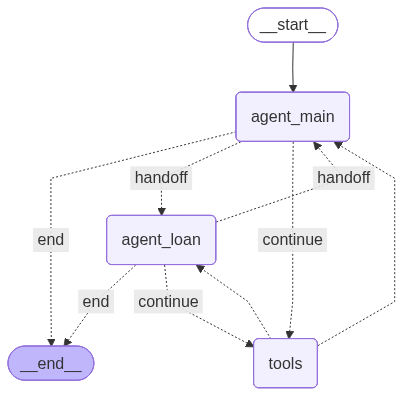

In [32]:
# === Visualize ===
from IPython.display import Image, display
display(Image(agentic_graph_m.get_graph().draw_mermaid_png()))

#Test time

In [33]:
# Test agent
agent_state = {
    "query": "Can I transfer my Current Account from one branch to another?",
    "last_agent_response": "",
    "tool_obervations": [],
    "num_steps": 0
}
result = agentic_graph_m.invoke(agent_state)


=== AGENT_MAIN ===
ACTION: get_related_bank_faq
ARGUMENTS: {"query": "transfer Current Account from one branch to another"}
Route to continue
--- ⚙️ CALLING TOOL OF(agent_main) ---
Tool requested: get_related_bank_faq
Allowed tools =  ['get_related_bank_faq', 'search_nearest_branch', 'web_search']
---TOOLCALL: RETRIEVING CONTEXT---
{'context': 'Question: Can I transfer my Current Account from one branch to another. Answer: Yes, Current Accounts can be transferred from one branch to another. However, there are certain restrictions. Please visit your nearest branch for details.. Class: accounts. ', 'source': 'Bank FAQ Knowledge Base'}

=== AGENT_MAIN ===
ANSWER: Yes, Current Accounts can be transferred from one branch to another. However, there are certain restrictions. Please visit your nearest branch for details.
Found ANSWER → ending workflow.


In [34]:
agent_state = {
    "query": "Can I know information about SHB (Sai Gon Ha Noi Bank)?",
    "last_agent_response": "",
    "tool_obervations": [],
    "num_steps": 0
}
result = agentic_graph_m.invoke(agent_state)


=== AGENT_MAIN ===
ACTION: web_search
ARGUMENTS: {"query": "SHB (Sai Gon Ha Noi Bank) information"}
Route to continue
--- ⚙️ CALLING TOOL OF(agent_main) ---
Tool requested: web_search
Allowed tools =  ['get_related_bank_faq', 'search_nearest_branch', 'web_search']
---TOOLCALL: PERFORMING WEB SEARCH---
{'context': 'Sample return from web: Ngân hàng TMCP Sài Gòn – Hà Nội (SHB), thành lập năm 1993 và niêm yết từ 2009, sau 32 năm phát triển đã khẳng định vị thế vững mạnh trong hệ thống tài chính Việt Nam và từng bước mở rộng ra quốc tế. SHB hiện có hơn 6.600 CBNV, gần 600 điểm giao dịch, phục vụ trên 5 triệu khách hàng và kết nối với 500 ngân hàng đại lý toàn cầu.Đến 30/6/2025, SHB đạt tổng tài sản gần 825 nghìn tỷ đồng, dư nợ cho vay hơn 594,5 nghìn tỷ đồng; lợi nhuận trước thuế 6 tháng đầu năm vượt 8.900 tỷ đồng, hoàn thành 61% kế hoạch năm. Ngân hàng thuộc Top 5 TMCP tư nhân lớn nhất về vốn điều lệ, duy trì hiệu quả hoạt động cao (CIR 16,4%, ROE trên 18%) và đang hoàn thiện quản trị rủ

In [35]:
agent_state = {
    "query": "I love this bank. Tell me nearest branch to visit right now",
    "last_agent_response": "",
    "tool_obervations": [],
    "num_steps": 0
}
result = agentic_graph_m.invoke(agent_state)


=== AGENT_MAIN ===
ACTION: search_nearest_branch
ARGUMENTS: {"user_location": "current_mobile_app_location"}
Route to continue
--- ⚙️ CALLING TOOL OF(agent_main) ---
Tool requested: search_nearest_branch
Allowed tools =  ['get_related_bank_faq', 'search_nearest_branch', 'web_search']
---SEARCHING NEAREST BRANCH---
{'context': [{'branch_name': 'SHB Chi nhánh Đồng Nai - PGD 51', 'branch_address': 'Số 222 Phạm Văn Thuận, Phường Tân Tiến, TP Biên Hòa, Đồng Nai', 'distance_km': 37.88}, {'branch_name': 'SHB Chi nhánh Bình Dương - PGD 80', 'branch_address': 'Số 481 Đại lộ Bình Dương, Phường Phú Cường, TP Thủ Dầu Một, Bình Dương', 'distance_km': 85.7}, {'branch_name': 'SHB Chi nhánh Vũng Tàu - PGD 86', 'branch_address': 'Số 151 Lê Hồng Phong, Phường 8, TP Vũng Tàu', 'distance_km': 87.62}], 'source': 'Branch Search'}

=== AGENT_MAIN ===
ANSWER: The nearest branch is SHB Chi nhánh Đồng Nai - PGD 51, located at Số 222 Phạm Văn Thuận, Phường Tân Tiến, TP Biên Hòa, Đồng Nai, which is 37.88 km away

In [36]:
agent_state = {
    "query": "Calculate for me the loan DTI",
    "last_agent_response": "",
    "last_agent":"",
    "tool_obervations": [],
    "num_steps": 0,
    "customer_no":"0310003896",
    "user_location": "Hanoi, Vietnam"
}
result = agentic_graph_m.invoke(agent_state,
                                config={"recursion_limit": 10})
print(result)


=== AGENT_MAIN ===
HANDOFF to Loan Expert Agent.
Route to handoff

=== AGENT_LOAN ===
ACTION: calculate_dti
ARGUMENTS: {}
Route to continue
--- ⚙️ CALLING TOOL OF(agent_loan) ---
Tool requested: calculate_dti
Allowed tools =  ['calculate_dti']
---TOOLCALL: PERFORMING DTI CALCULATION---
{'context': 0.6, 'source': 'caculate_dti'}

=== AGENT_LOAN ===
The DTI for the loan is 0.6.
{'query': 'Calculate for me the loan DTI', 'last_agent_response': 'The DTI for the loan is 0.6.', 'last_agent': 'agent_loan', 'tool_obervations': ['[calculate_dti results: 0.6]'], 'num_steps': 3, 'user_location': 'Hanoi, Vietnam'}
